# Statistics Project 

Work done by: Guilherme Alves, Tomás Gonçalves, Bárbara Baptista, João Simões

Imported libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import scale
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy import stats
from IPython.display import display, HTML
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import random
import enum

# figures inline in notebook
%matplotlib inline
np.set_printoptions(suppress=True)
pd.set_option('display.max_rows', 20)

# Main project (Only one dependent variable)

We decided to use the "Student Performance Dataset" because it allows us to test multiple topics learned in class.

In [2]:
data = pd.read_csv("Student_Performance.csv", header=None)

data.head()

,0,1,2,3,4,5
0,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
1,7,99,Yes,9,1,91.0
2,4,82,No,4,2,65.0
3,8,51,Yes,7,2,45.0
4,5,52,Yes,5,2,36.0


The "Performance Index" represents the overall result of the student's academic perfomance. Therefore, it makes sense to treat it as the dependent variable, with the other variables influencing it.

In [3]:
data.columns = ["V"+str(i) for i in range(1, len(data.columns)+1)]

x = data.loc[:, "V1":"V5"]  #Independent Variables
y = data.V6  #Dependent Variable

data

,V1,V2,V3,V4,V5,V6
0,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
1,7,99,Yes,9,1,91.0
2,4,82,No,4,2,65.0
3,8,51,Yes,7,2,45.0
4,5,52,Yes,5,2,36.0
...,...,...,...,...,...,...
9996,1,49,Yes,4,2,23.0
9997,7,64,Yes,8,5,58.0
9998,6,83,Yes,8,5,74.0
9999,9,97,Yes,7,0,95.0


## Objectives and first thoughts

The objective of this project is to statistically analyze the influence of the independent variables on the "Performance Index".

Before performing any statistical analysis, it is important to first consider how the dependent variable may vary with the others. Although it does not describe every student, grades tend to remain consistent from year to year. We predict that studying more hours will improve the "Performance Index", answering more sample question papers will also help, and participating in extracurricular activities may further enhance the index.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   V1      10001 non-null  object
 1   V2      10001 non-null  object
 2   V3      10001 non-null  object
 3   V4      10001 non-null  object
 4   V5      10001 non-null  object
 5   V6      10001 non-null  object
dtypes: object(6)
memory usage: 468.9+ KB


The pandas library identifies every attribute as an object. Therefore, we need to convert each type to float, except for "Extracurricular Activities", which will be binary: "Yes" as 1 and "No" as 0.

In [5]:
data["V3"] = data["V3"].map({"Yes": 1, "No": 0})
cols_to_convert = [c for c in data.columns if c != "V3"]
data[cols_to_convert] = data[cols_to_convert].apply(pd.to_numeric, errors='coerce')


data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      10000 non-null  float64
 1   V2      10000 non-null  float64
 2   V3      10000 non-null  float64
 3   V4      10000 non-null  float64
 4   V5      10000 non-null  float64
 5   V6      10000 non-null  float64
dtypes: float64(6)
memory usage: 468.9 KB


## Data Visualization

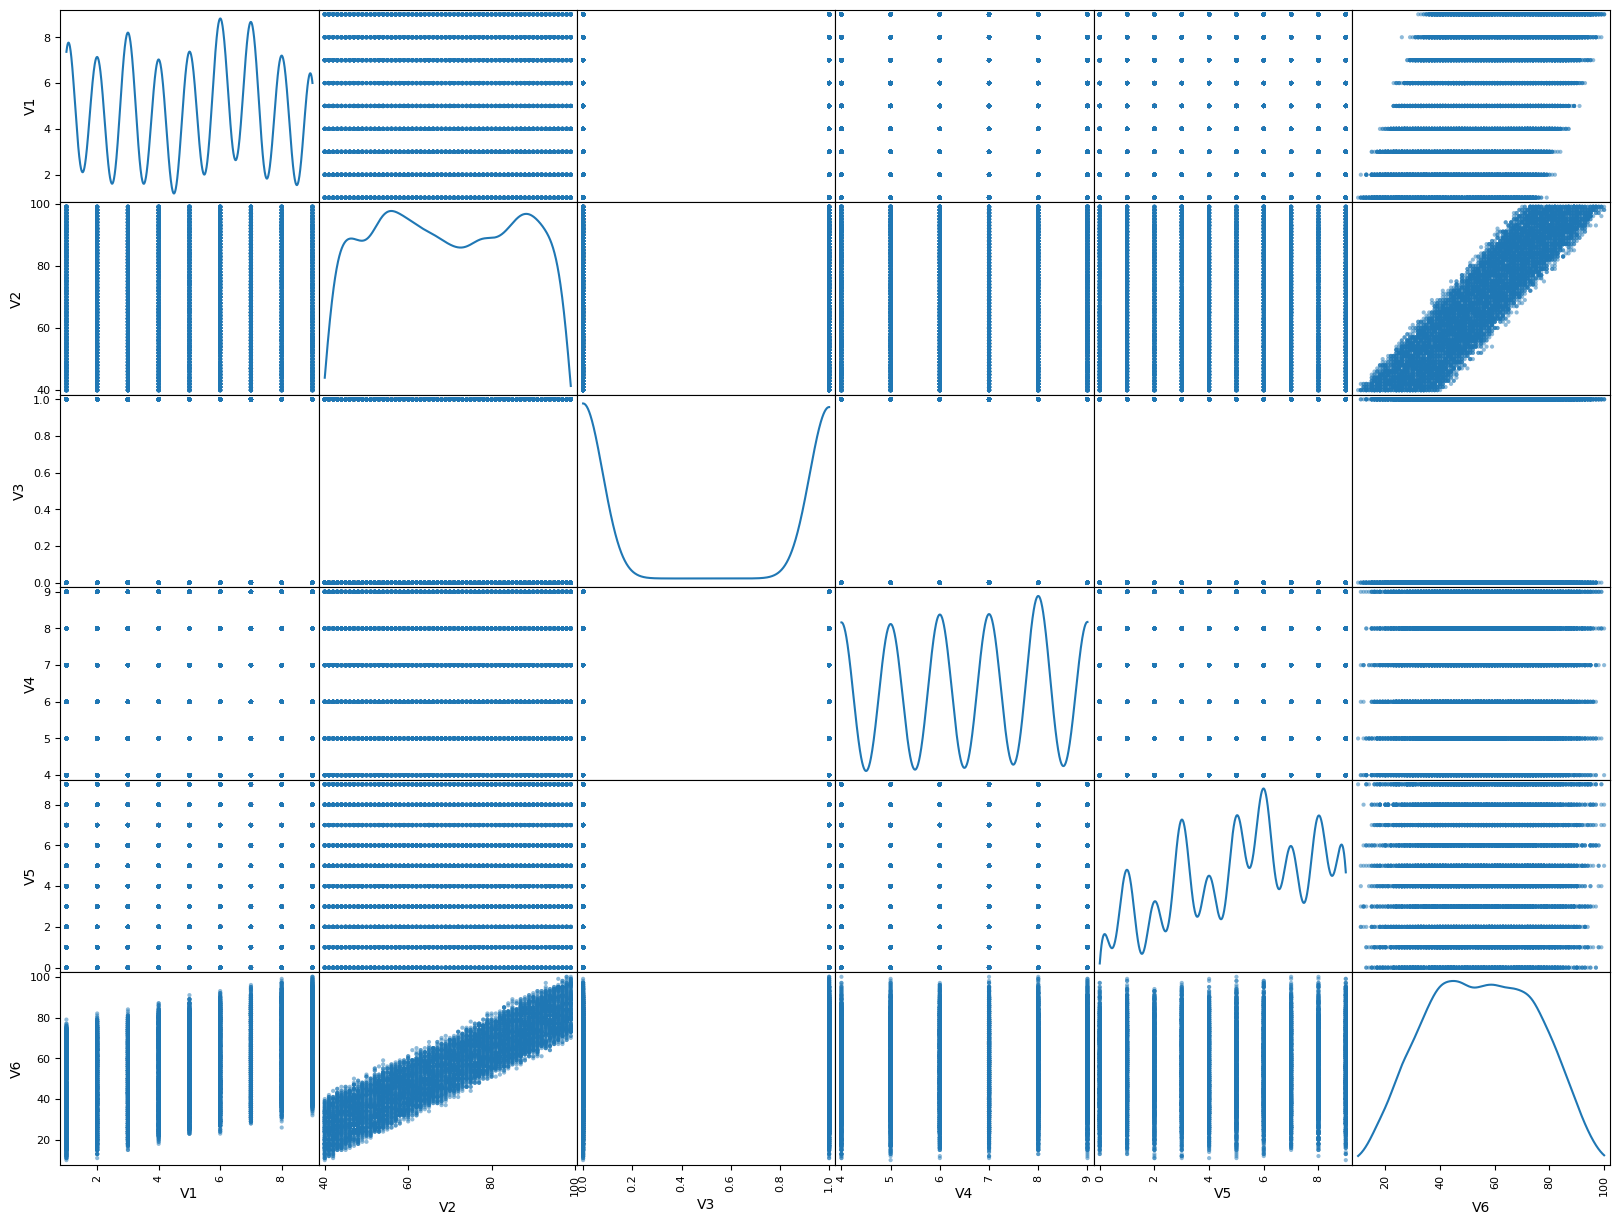

In [6]:
subset = data.loc[:, "V1":"V6"]
pd.plotting.scatter_matrix(subset, diagonal="kde", figsize=(20,15))
plt.show()

The scatter plot is used for visualization purposes. However, studying variables with a small number of groups using scatter plots is not meaningful.

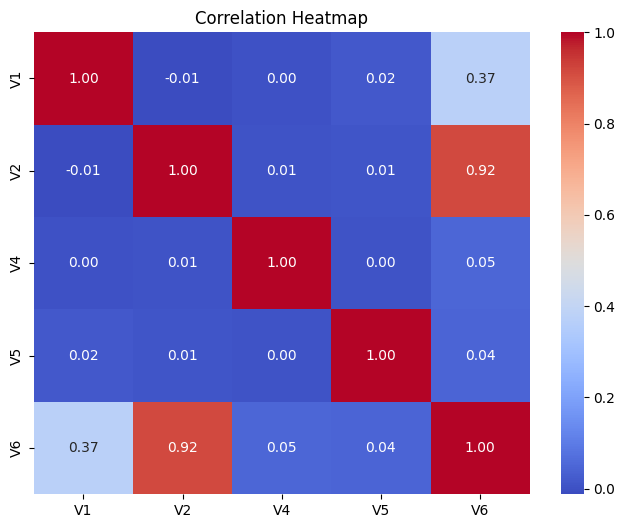

In [7]:
numeric_cols = ["V1","V2", "V4", "V5", "V6"]  
corr_matrix = data[numeric_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

We can already observe that V2 ("Previous Scores") and V1 ("Hours Studied") have a positive correlation. 

However, we can also see that the independent variables are not correlated with each other (mainly due to the low number of groups in each variable).

In [8]:
subset.V6.describe()

count    10000.000000
mean        55.224800
std         19.212558
min         10.000000
25%         40.000000
50%         55.000000
75%         71.000000
max        100.000000
Name: V6, dtype: float64

<Axes: ylabel='Frequency'>

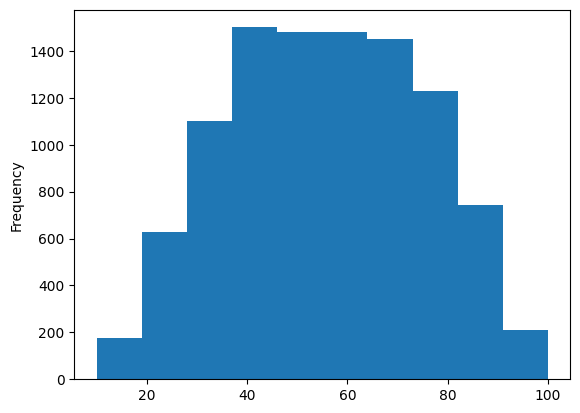

In [9]:
subset.V6.plot(kind="hist")

C:\Users\jpsim\AppData\Local\Temp\ipykernel_11212\2279030358.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(subset.V6, fit = norm)


<Axes: xlabel='V6', ylabel='Density'>

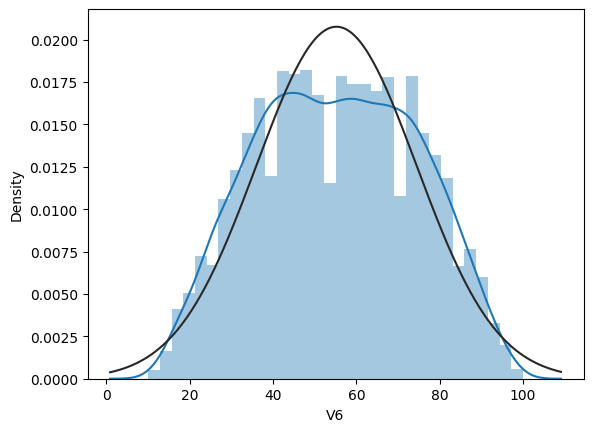

In [10]:
sns.distplot(subset.V6, fit = norm)

It makes sense that the "Perfomance Index" follows a normal distribution. According to the Central Limit Theorem and the Law of Large Numbers, the sum of different independent random variables tends to follow a normal distribution overall.

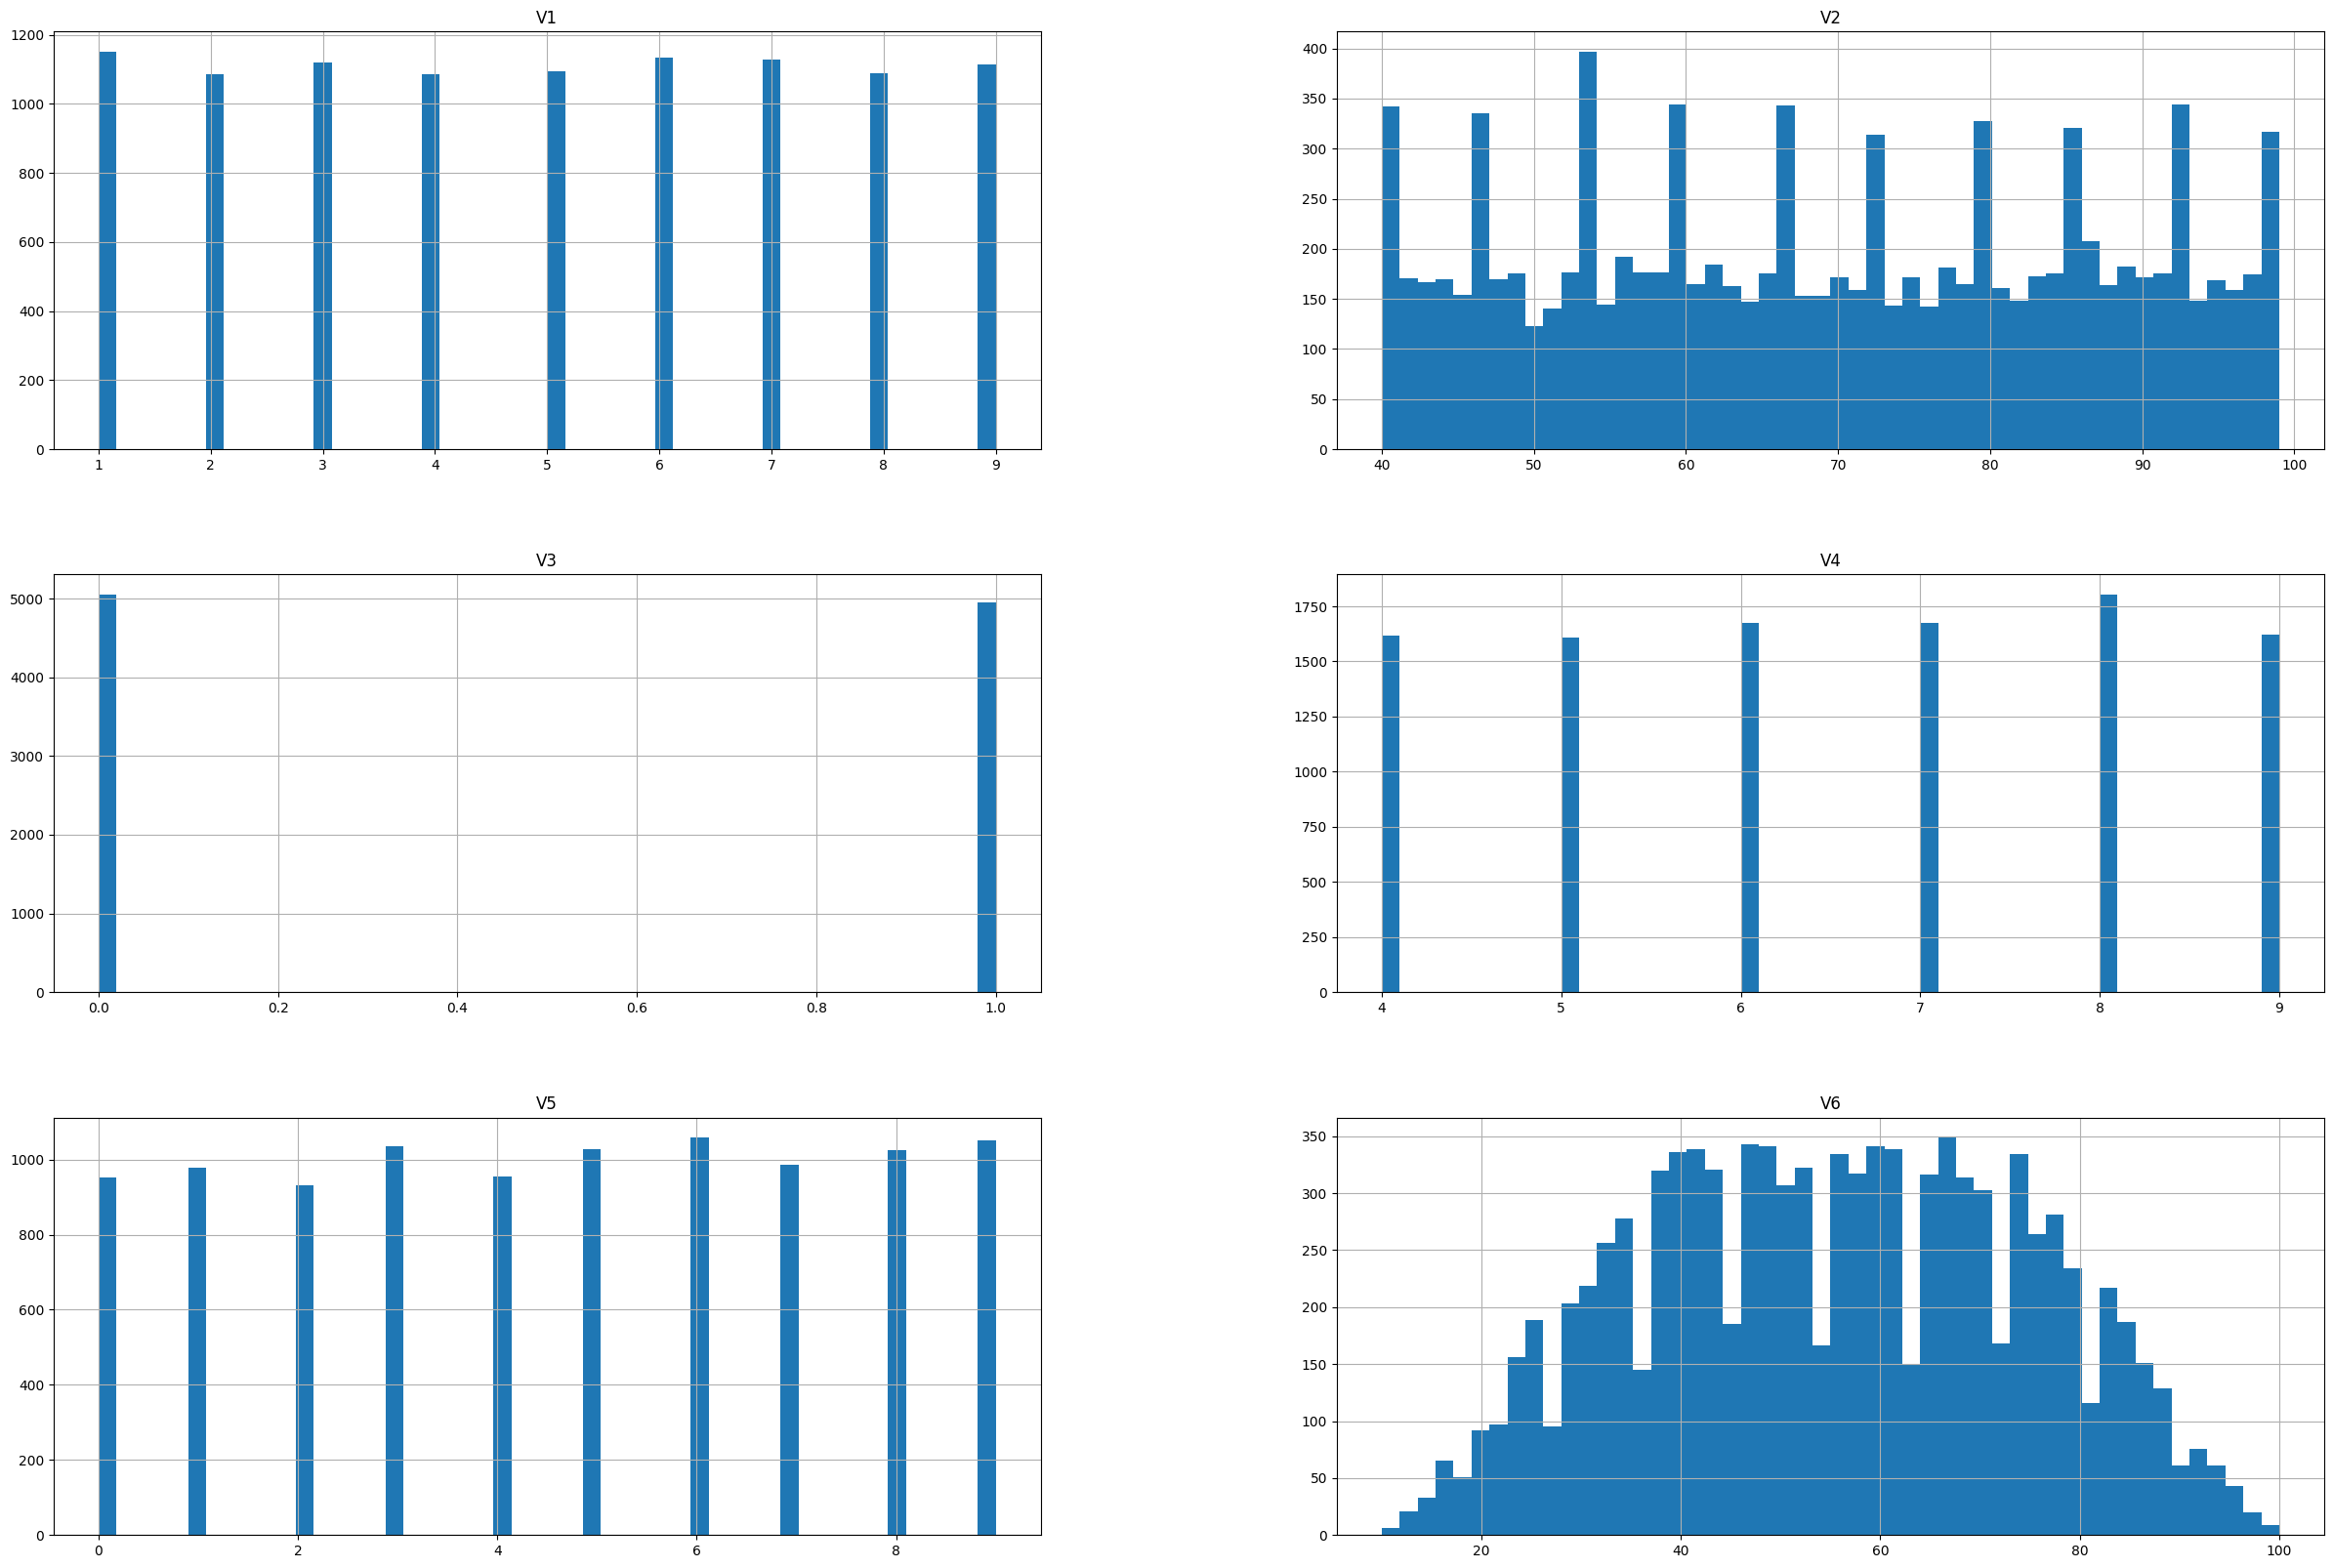

In [11]:
subset.hist(bins=50, figsize=(30,20));

Although not very useful, we can observe that the "Previous Scores" variable shows several spikes at intervals of five points. This can be explained by natural digit preference: the previous professor tended to choose numbers ending in 0 or 5.

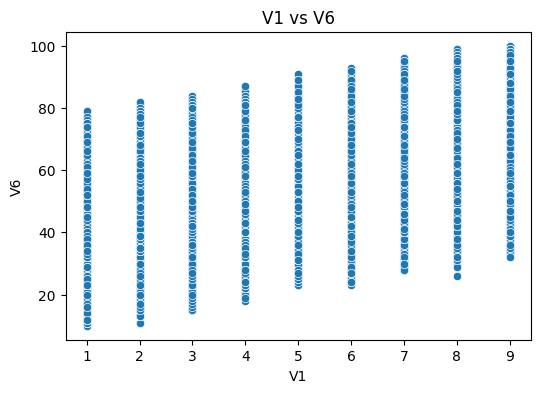

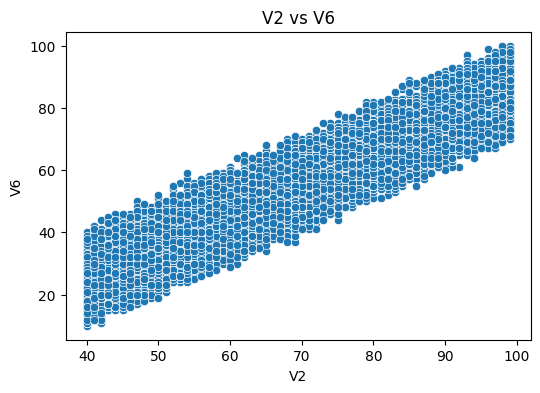

In [12]:
features = ["V1", "V2"]
target = "V6"

# Individual scatter plots
for feature in features:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=feature, y=target, data=data)
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.title(f"{feature} vs {target}")
    plt.show()

These are the only graphs where we can visually observe a clear trend. 

## First Analysis: Does students doing Extracurricular Activities influence the Perfomance Index? 

Since "Extracurricular Activies" has only two groups, we will start with this variable.

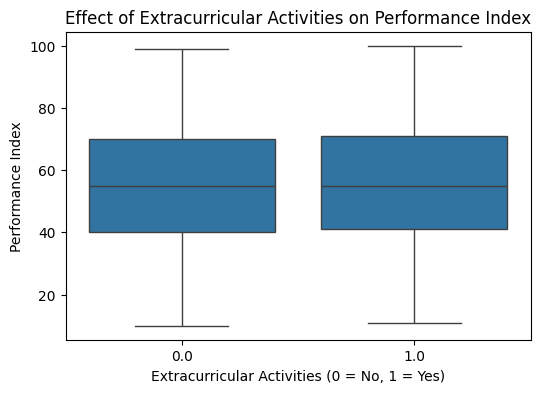

In [13]:
plt.figure(figsize=(6,4))
sns.boxplot(x="V3", y="V6", data=data)

plt.xlabel("Extracurricular Activities (0 = No, 1 = Yes)")
plt.ylabel("Performance Index")
plt.title("Effect of Extracurricular Activities on Performance Index")

plt.show()

Since we are dealing with discrete groups, there is a necessity to use bloxplots. Histograms and other forms of plotting do not visually display trends as clearly.

We can observe a small increase in the performance of students who participate in extracurricular activities, but we need to verify if this difference is statistically significant.

Since we are comparing two samples, we will use the Student’s t-test, which is an appropriate method for this purpose.

In [14]:
data.groupby("V3")["V6"].mean() # Extracurricular Activities means of Perfomance Index

V3
0.0    54.758511
1.0    55.700889
Name: V6, dtype: float64

In [15]:
group0 = data[data["V3"]==0]["V6"]
group1 = data[data["V3"]==1]["V6"]

t_stat, p_value = ttest_ind(group0, group1)
print("t =", t_stat, "p =", p_value)

t = -2.452987248811042 p = 0.01418449156855449


Because t is negative, we can conclude that the "Performance Index" of students participating in extracurricular activities is higher. With $p = 0.014 < 0.05$, we can state that the difference between groups is statistically significant.

## "Hours Of Sleep" VS "Performance Index"

In [16]:
data[["V4","V6"]].corr()


,V4,V6
V4,1.000000,0.048106
V6,0.048106,1.000000


The linear correlation is weak, which makes sense since V4 ("Hours of Sleep") is divided into a small number of groups (six groups), so we need to consider other approaches.

Since "Hours of Sleep" is a categorical variable with three or more groups, we need to apply an ANOVA (Analysis of Variance).

In [17]:
groups = [data[data["V4"]==h]["V6"] for h in sorted(data["V4"].unique())]

print(data["V4"].value_counts().sort_index())

V4
4.0    1619
5.0    1606
6.0    1673
7.0    1676
8.0    1804
9.0    1622
Name: count, dtype: int64


In [18]:
groups = [data[data["V4"]==h]["V6"] for h in sorted(data["V4"].unique()) if len(data[data["V4"]==h]) > 0]

f_stat, p_value = f_oneway(*groups)
print("F-statistic:", f_stat)
print("p-value:", p_value)

F-statistic: 4.952021099081804
p-value: 0.00015687016637197588


Using ANOVA, with $p= 0.0016 < 0.05$, we can confirm that the differences between the "Sleep Hours" groups are statistically significant, allowing us to identify a trend among the means.

In [19]:
mean_v6 = data.groupby("V4")["V6"].mean().sort_index()
print(mean_v6)

V4
4.0    53.794935
5.0    54.801370
6.0    54.660490
7.0    55.278043
8.0    55.932373
9.0    56.811344
Name: V6, dtype: float64


Clearly, we can see that sleeping more hours leads to a higher "Performance Index".

C:\Users\jpsim\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


                            WLS Regression Results                            
Dep. Variable:                V6_mean   R-squared:                       0.937
Model:                            WLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     59.21
Date:                Sat, 25 Oct 2025   Prob (F-statistic):            0.00153
Time:                        20:04:27   Log-Likelihood:              -0.029621
No. Observations:                   6   AIC:                             4.059
Df Residuals:                       4   BIC:                             3.643
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.6656      0.477    108.334      0.0

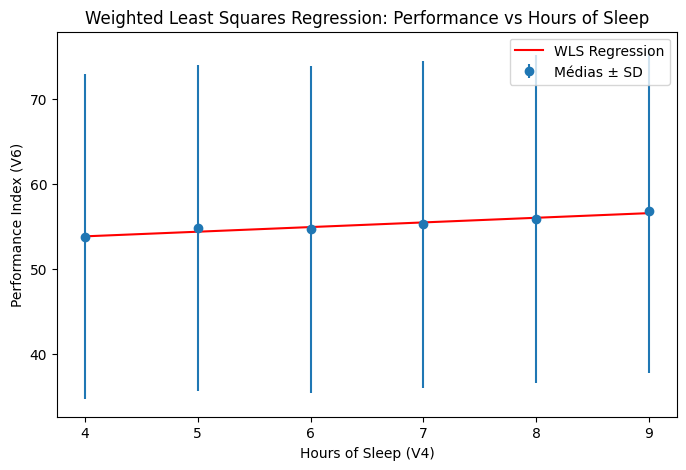

In [20]:
group_stats = data.groupby("V4")["V6"].agg(['mean', 'std', 'count']).reset_index()
group_stats.rename(columns={'mean':'V6_mean','std':'V6_std','count':'N'}, inplace=True)


X = group_stats["V4"]            
y = group_stats["V6_mean"]       
weights = 1 / (group_stats["V6_std"]**2)  

weights.replace([np.inf, -np.inf], 0, inplace=True)  


X_const = sm.add_constant(X)


wls_model = sm.WLS(y, X_const, weights=weights)
results = wls_model.fit()

print(results.summary())


plt.figure(figsize=(8,5))
plt.errorbar(group_stats["V4"], group_stats["V6_mean"], yerr=group_stats["V6_std"], fmt='o', label="Médias ± SD")
plt.plot(group_stats["V4"], results.fittedvalues, color='red', label="WLS Regression")
plt.xlabel("Hours of Sleep (V4)")
plt.ylabel("Performance Index (V6)")
plt.title("Weighted Least Squares Regression: Performance vs Hours of Sleep")
plt.legend()
plt.show()

## "Sample Question Papers Practiced"	VS "Performance Index"

In [21]:
groups = [data[data["V5"]==h]["V6"] for h in sorted(data["V5"].unique()) if len(data[data["V5"]==h]) > 0]

f_stat, p_value = f_oneway(*groups)
print("F-statistic:", f_stat)
print("p-value:", p_value)

F-statistic: 3.1992232898749724
p-value: 0.000710816871057489


Since $p<0.05$, the result is statistically significant.

In [22]:
mean_v5 = data.groupby("V5")["V6"].mean().sort_index()
print(mean_v5)

V5
0.0    52.946372
1.0    54.606339
2.0    55.264516
3.0    55.257005
4.0    54.148691
5.0    55.451362
6.0    56.147309
7.0    55.776089
8.0    55.454191
9.0    56.880114
Name: V6, dtype: float64


We can observe a positive trend in performance as the number of "Sample Question Papers Practiced" increases.

                            WLS Regression Results                            
Dep. Variable:                V6_mean   R-squared:                       0.643
Model:                            WLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     14.42
Date:                Sat, 25 Oct 2025   Prob (F-statistic):            0.00526
Time:                        20:04:31   Log-Likelihood:                -9.3426
No. Observations:                  10   AIC:                             22.69
Df Residuals:                       8   BIC:                             23.29
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         53.8922      0.404    133.313      0.0

C:\Users\jpsim\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


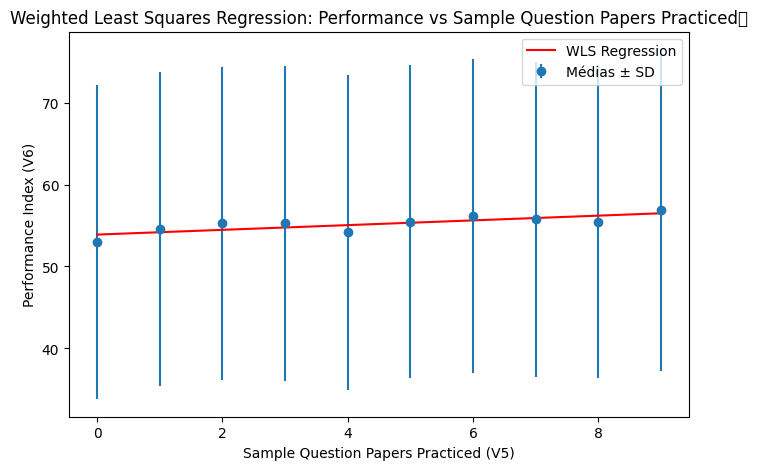

In [23]:

group_stats = data.groupby("V5")["V6"].agg(['mean', 'std', 'count']).reset_index()
group_stats.rename(columns={'mean':'V6_mean','std':'V6_std','count':'N'}, inplace=True)


X = group_stats["V5"]            
y = group_stats["V6_mean"]       
weights = 1 / (group_stats["V6_std"]**2)  


weights.replace([np.inf, -np.inf], 0, inplace=True)  


X_const = sm.add_constant(X)


wls_model = sm.WLS(y, X_const, weights=weights)
results = wls_model.fit()

print(results.summary())


plt.figure(figsize=(8,5))
plt.errorbar(group_stats["V5"], group_stats["V6_mean"], yerr=group_stats["V6_std"], fmt='o', label="Médias ± SD")
plt.plot(group_stats["V5"], results.fittedvalues, color='red', label="WLS Regression")
plt.xlabel("Sample Question Papers Practiced (V5)")
plt.ylabel("Performance Index (V6)")
plt.title("Weighted Least Squares Regression: Performance vs Sample Question Papers Practiced	")
plt.legend()
plt.show()

We can see a positive trend for the “Sample Question Papers Practiced” variable. Interestingly, its coefficient is lower than that of “Sleep Hours”. Therefore, based on this dataset, we can conclude that sleeping more tends to yield better results than completing more exercises.

## Multi Linear Regression

                            OLS Regression Results                            
Dep. Variable:                     V6   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 1.215e+05
Date:                Sat, 25 Oct 2025   Prob (F-statistic):               0.00
Time:                        20:04:33   Log-Likelihood:                -14950.
No. Observations:                7000   AIC:                         2.991e+04
Df Residuals:                    6994   BIC:                         2.995e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -33.8365      0.153   -221.228      0.0

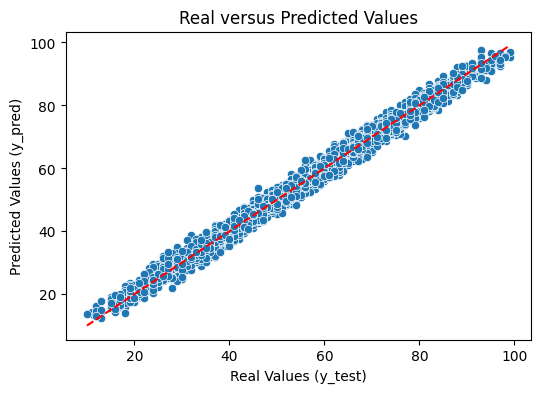

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


data = data.dropna(subset=["V1", "V2", "V3", "V4", "V5", "V6"])



X = data[["V1", "V2", "V3", "V4", "V5"]]
y = data["V6"]


X = sm.add_constant(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


model = sm.OLS(y_train, X_train).fit()


print(model.summary())


y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Model Evaluation ---")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")


plt.figure(figsize=(6,4))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Real Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("Real versus Predicted Values")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()


We can observe that the coefficients of each attribute in the multiple linear regression differ from those obtained in the individual linear regressions. This makes sense because multiple linear regression can separate the effect of each variable in an efficient and accurate way.

## Conclusion and Discussion

Using this dataset, we can conclude that sleeping more hours, participating in extracurricular activities, studying more, and practicing sample questions all improve the "Performance Index".

Despite these strong conclusions, we believe there is a plateau effect for these independent variables. Sleeping 15 hours should not improve the Performance Index compared to sleeping 9 hours; on the contrary, it should decrease performance, as the student loses valuable time by sleeping too much.

Although studying more hours tends to improve performance, the relationship is unlikely to remain linear when considering higher study times.

PCA and other dimensionality reduction methods were not applied to this dataset because there was only one dependent variable. K-means clustering was also not performed, as there was no justifiable reason to use it in this context.

# Monte Carlo Simulation

## Introduction


In this Monte Carlo analysis, the main objective is to illustrate how the Monte Carlo method can be applied to simulate complex games like Blackjack and to extract meaningful statistical insights from repeated trials.

To achieve this, the analysis defines the game rules and the dealer’s policy, which follows a standard deterministic behaviour: drawing until reaching 17. It then implements different player strategies, in  this case, 2 discrete rule-based policies, to represent distinct decision-making approaches during gameplay.

We used a pre-existing Python code that simulates the Blackjack game under simplified rules. The code was slightly modified to better align with the objectives of this analysis, enabling the collection and visualization of key performance metrics such as average net return, win rate, and outcome distribution. 

By running thousands of simulated rounds, we can observe the average net profit and distribution of outcomes (wins, ties, and losses) for each strategy. This approach is particularly valuable because it allows us to assess performance in situations where analytical computation of probabilities is extremely complex.

## Set up the game.

### Blackjack Game Description (Simplified Version)

Blackjack is a card game played between a player and a dealer. The goal is to reach a hand value as close as possible to 21 points without exceeding it.  

---

**Card Values**
- Cards 2–10 are worth their face value.  
- Jack, Queen and King are each worth 10 points  
- The Ace can count as 1 or 11 whichever benefits the player more.  

---

**Game Rules**
1. Both the player and the dealer start with two cards. The dealer shows one card face up and keeps the other face down.  
2. The player can:
   - Hit → take another card to increase their total.  
   - Stand → keep their current hand and end their turn.  
3. If the player’s total exceeds 21 they bust and lose the round.  
4. After the player finishes, the dealer reveals their hidden card and must hit until reaching at least 17 points  
5. The round outcome is decided as follows:
   - Player busts → loss  
   - Dealer busts → win  
   - Neither busts → closest to 21 wins  
   - Equal totals → tie   

---

**Payout Rules**
In this simplified version (no splitting, insurance, or double down):  
- Win: +\$100  
- Loss: −\$100  
- Tie: no change  




Define the rank and suit of a card.

In [25]:
ranks = {
    "two" : 2,
    "three" : 3,
    "four" : 4,
    "five" : 5,
    "six" : 6,
    "seven" : 7,
    "eight" : 8,
    "nine" : 9,
    "ten" : 10,
    "jack" : 10,
    "queen" : 10,
    "king" : 10,
    "ace" : (1, 11)
}
    
class Suit(enum.Enum):
    spades = "spades"
    clubs = "clubs"
    diamonds = "diamonds"
    hearts = "hearts"

Define a card and a deck.

Implement shuffle, peek, & deal functions for the deck.

In [26]:
class Card:
    def __init__(self, suit, rank, value):
        self.suit = suit
        self.rank = rank
        self.value = value
        
    def __str__(self):
        return self.rank + " of " + self.suit.value

class Deck:
    def __init__(self, num=1):
        self.cards = []
        for i in range(num):
            for suit in Suit:
                for rank, value in ranks.items():
                    self.cards.append(Card(suit, rank, value))
                
    def shuffle(self):
        random.shuffle(self.cards)
        
    def deal(self):
        return self.cards.pop(0)
    
    def peek(self):
        if len(self.cards) > 0:
            return self.cards[0]
        
    def add_to_bottom(self, card):
        self.cards.append(card)
        
    def __str__(self):
        result = ""
        for card in self.cards:
            result += str(card) + "\n"
        return result
    
    def __len__(self):
        return len(self.cards)

 **Set up Blackjack**

### Define logic for evaluating the value of the dealer's hand.

Trickiest part is defining the logic for Aces.

_Dealer Logic will not change much! They must follow a set, predictable course of action._

In [27]:
# This follows the same, official rules every time.
# Still need to figure out what happens if there are multiple Aces.
def dealer_eval(player_hand):
    num_ace = 0
    use_one = 0
    for card in player_hand:
        if card.rank == "ace":
            num_ace += 1
            use_one += card.value[0] # use 1 for Ace
        else:
            use_one += card.value
    
    if num_ace > 0:
        # See if using 11 instead of 1 for the Aces gets the 
        # dealer's hand value closer to the [17, 21] range
        
        # The dealer will follow Hard 17 rules.
        # This means the dealer will not hit again if
        # the Ace yields a 17. 
        
        # This also means that Aces initially declared as 11's can
        # be changed to 1's as new cards come.
        
        ace_counter = 0
        while ace_counter < num_ace:
            # Only add by 10 b/c 1 is already added before
            use_eleven = use_one + 10 
            
            if use_eleven > 21:
                return use_one
            elif use_eleven >= 17 and use_eleven <= 21:
                return use_eleven
            else:
                # The case where even using Ace as eleven is less than 17.
                use_one = use_eleven
            
            ace_counter += 1
        
        return use_one
    else:
        return use_one

### Define logic for evaluating the value of the player's hand.

Trickiest part is defining the logic for Aces. This logic can be implemented in different ways. The opted approach tries to use an Ace as an 11 whenever possible, and only uses the Ace as a 1 when the alternative would make the player bust.

In [28]:
def player_eval(player_hand):
    num_ace = 0
    # use_one means that every ace that in the hand is counted as one.
    use_one = 0
    for card in player_hand:
        if card.rank == "ace":
            num_ace += 1
            use_one += card.value[0] # use 1 for Ace
        else:
            use_one += card.value
    
    if num_ace > 0:
        # Define player policy for Aces:
        # Make Aces 11 if they get you to the range [18,21]
        # Otherwise, use one.
        
        ace_counter = 0
        while ace_counter < num_ace:
            # Only add by 10 b/c 1 is already added before
            use_eleven = use_one + 10 
            
            if use_eleven > 21:
                return use_one
            elif use_eleven >= 18 and use_eleven <= 21:
                return use_eleven
            else:
                # This allows for some Aces to be 11s, and others to be 1.
                use_one = use_eleven
            
            ace_counter += 1
        
        return use_one
    else:
        return use_one

### Define logic for the dealer's turn.

This will not change much since the dealer has to follow a defined protocol when making their moves( the dealer keeps hitting until his total is 17 or more)

In [29]:
def dealer_turn(dealer_hand, deck):
    # Calculate dealer hand's value.
    dealer_value = dealer_eval(dealer_hand)

    # Define dealer policy (is fixed to official rules)

    # The dealer keeps hitting until their total is 17 or more
    while dealer_value < 17:
        # hit
        dealer_hand.append(deck.deal())
        dealer_value = dealer_eval(dealer_hand)

    return dealer_value, dealer_hand, deck

### Main Blackjack play_game() function.

Can use higher-order functions functionality to pick which player policy to use.

In [30]:
def play_game(player_policy, num_decks = 2, start_cash = 10000000, num_rounds = 100):
    # Our Blackjack deck will be made of 2 normal decks by default.
    bj_deck = Deck(num_decks)

    # Shuffle before beginning. Only shuffle once before the start of each game.
    bj_deck.shuffle()
    
    # Keeps track of rewards/punishments. Also allows game to end before num_rounds.
    player_cash = start_cash
    wins=0
    losses=0
    ties=0
    rounds_played = 0
    
    while rounds_played < num_rounds and player_cash > 0:
        # Assume player bets 100 each round.
        # Gains 100 for winning round.
        # Loses 100 for losing round.
        # Nothing happens if tie. (Needs to change when actually training, so that agent tries to win more than tie.)
        bet=100
        
        player_hand = [bj_deck.deal(), bj_deck.deal()]
        dealer_hand = [bj_deck.deal(), bj_deck.deal()]
        
        # The current policy does not care about dealer's upcard.
        #dealer_upcard = dealer_hand[0]
        
        ## Begin player turn phase.
        
        player_value, player_hand, bj_deck = player_policy(player_hand, bj_deck)
            
        ## Player turn phase over.
        
        #--------------------------------------------------------#
        
        ## Begin automated phase of the Dealer's Play and
        ## determining the winner of the round.
        
        if player_value > 21: # above 21, player loses automatically.
            player_cash -= bet
            losses+=1
        elif player_value == 21: # blackjack! Player wins automatically.
            player_cash += bet
            wins+=1
        else:
            ## Begin dealer turn phase.
            
            dealer_value, dealer_hand, bj_deck = dealer_turn(dealer_hand, bj_deck)
                
            ## End of dealer turn phase
            
            #------------------------------------------------------------#
            
            ## Final Compare
            
            if dealer_value > 21: # dealer above 21, player wins automatically
                player_cash += bet
                wins+=1
            elif dealer_value == 21: # dealer has blackjack, player loses automatically
                player_cash -= bet
                losses+=1
            else: # dealer and player have values less than 21.
                if player_value > dealer_value: # player closer to 21, player wins.
                    player_cash += bet
                    wins+=1
                elif player_value < dealer_value: # dealer closer to 21, dealer wins.
                    player_cash -= bet
                    losses+=1
                # Nothing happens if a tie.
                
        ## End of round formalities
        
        # Add all cards to the end of deck, and shuffle. 
        # (Shuffling not usually done in casino blackjack.)
        bj_deck.cards += player_hand
        bj_deck.cards += dealer_hand
        bj_deck.shuffle()
            
        rounds_played += 1
        
    # Returns %net gains/losses of playing
    return (player_cash - start_cash)/(num_rounds*bet)*100 , wins, losses

## Defining Policies


**Discrete Policy 1**

If hand >= 18: player stands.  
Else: Player hits.

In [31]:
def discrete_policy1(player_hand, deck):
    player_value = player_eval(player_hand)
    
    # Implement Discrete Policy
    # If hand >= 18, stand. Otherwise, hit.
    while player_value < 18:
        # hit
        player_hand.append(deck.deal())
        player_value = player_eval(player_hand)
        
    return player_value, player_hand, deck

 **Discrete Policy 2**

If hand >= 13: player stands.  
Else: Player hits.

In [32]:
def discrete_policy2(player_hand, deck):
    player_value = player_eval(player_hand)
    
    # Implement Discrete Policy
    # If hand >= 13, stand. Otherwise, hit.
    while player_value < 13:
        # hit
        player_hand.append(deck.deal())
        player_value = player_eval(player_hand)
        
    return player_value, player_hand, deck

## Simulation and Results

**Using Discrete Policy 1** 

4 Runs 100 games of 1 round

--- Run 1 ---
Average net return (%): 4.0000
Win rate (%): 46.00

--- Run 2 ---
Average net return (%): -7.0000
Win rate (%): 45.00

--- Run 3 ---
Average net return (%): -7.0000
Win rate (%): 42.00

--- Run 4 ---
Average net return (%): -19.0000
Win rate (%): 37.00



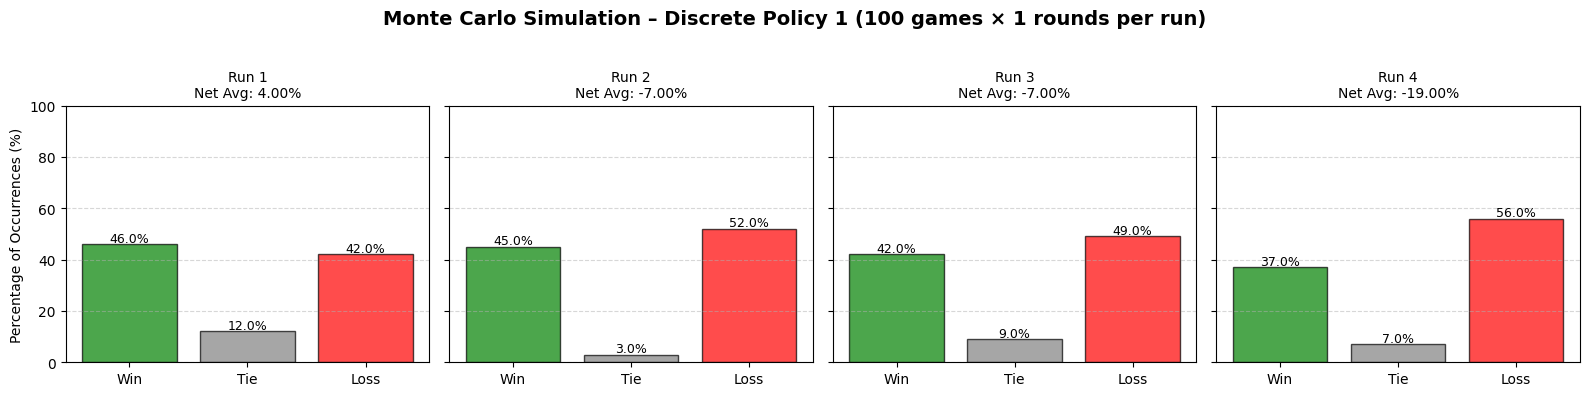

In [45]:
# Parameters
num_rds = 1
num_games = 100
num_runs = 4

# Prepare figure
fig, axes = plt.subplots(1, num_runs, figsize=(16, 4), sharey=True)
fig.suptitle(f"Monte Carlo Simulation – Discrete Policy 1 ({num_games} games × {num_rds} rounds per run)",
             fontsize=14, fontweight="bold")

for run in range(num_runs):
    results = {}
    wins = 0
    losses = 0
    ties = 0
    returns = []

    # Play multiple games
    for i in range(num_games):
        result = play_game(discrete_policy1, num_rounds=num_rds)
        returns.append(result[0])
        wins += result[1]
        losses += result[2]

    # Compute stats
    winp = wins / (num_games * num_rds) * 100
    lossp = losses / (num_games * num_rds) * 100
    tiep = 100 - (winp + lossp)
    net_avg = sum(returns) / num_games

    # Print summary
    print(f"--- Run {run + 1} ---")
    print(f"Average net return (%): {net_avg:.4f}")
    print(f"Win rate (%): {winp:.2f}")
   
    print()

    # Plot
    categories = ["Win", "Tie", "Loss"]
    percentages = [winp, tiep, lossp]

    ax = axes[run]
    bars = ax.bar(categories, percentages, color=["green", "gray", "red"],
                  alpha=0.7, edgecolor="black")

    ax.set_title(f"Run {run + 1}\nNet Avg: {net_avg:.2f}%", fontsize=10)
    ax.set_ylim(0, 100)
    ax.grid(axis="y", linestyle="--", alpha=0.5)

    # Add values on top of bars
    for i, v in enumerate(percentages):
        ax.text(i, v + 1, f"{v:.1f}%", ha="center", fontsize=9)

axes[0].set_ylabel("Percentage of Occurrences (%)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


**Using Discrete Policy 1** 

4 Runs 100000 games of 1 round

--- Run 1 ---
Average net return (%): -9.0660
Win rate (%): 41.84

--- Run 2 ---
Average net return (%): -9.8860
Win rate (%): 41.39

--- Run 3 ---
Average net return (%): -9.9100
Win rate (%): 41.36

--- Run 4 ---
Average net return (%): -9.8340
Win rate (%): 41.36



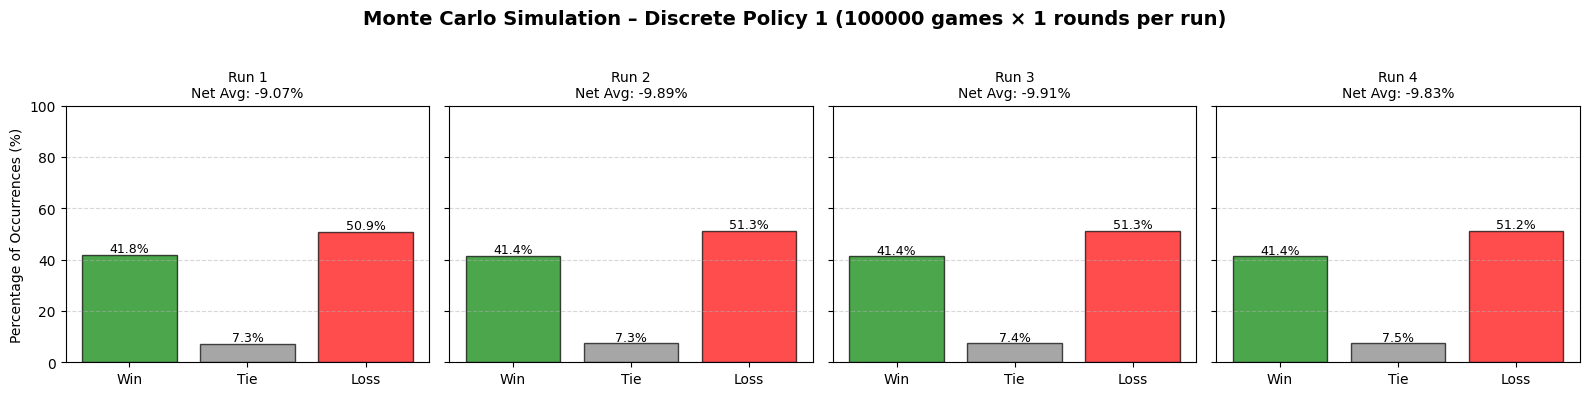

In [46]:
# Parameters
num_rds = 1
num_games = 100000
num_runs = 4

# Prepare figure
fig, axes = plt.subplots(1, num_runs, figsize=(16, 4), sharey=True)
fig.suptitle(f"Monte Carlo Simulation – Discrete Policy 1 ({num_games} games × {num_rds} rounds per run)",
             fontsize=14, fontweight="bold")

for run in range(num_runs):
    results = {}
    wins = 0
    losses = 0
    ties = 0
    returns = []

    # Play multiple games
    for i in range(num_games):
        result = play_game(discrete_policy1, num_rounds=num_rds)
        returns.append(result[0])
        wins += result[1]
        losses += result[2]

    # Compute stats
    winp = wins / (num_games * num_rds) * 100
    lossp = losses / (num_games * num_rds) * 100
    tiep = 100 - (winp + lossp)
    net_avg = sum(returns) / num_games

    # Print summary
    print(f"--- Run {run + 1} ---")
    print(f"Average net return (%): {net_avg:.4f}")
    print(f"Win rate (%): {winp:.2f}")
   
    print()

    # Plot
    categories = ["Win", "Tie", "Loss"]
    percentages = [winp, tiep, lossp]

    ax = axes[run]
    bars = ax.bar(categories, percentages, color=["green", "gray", "red"],
                  alpha=0.7, edgecolor="black")

    ax.set_title(f"Run {run + 1}\nNet Avg: {net_avg:.2f}%", fontsize=10)
    ax.set_ylim(0, 100)
    ax.grid(axis="y", linestyle="--", alpha=0.5)

    # Add values on top of bars
    for i, v in enumerate(percentages):
        ax.text(i, v + 1, f"{v:.1f}%", ha="center", fontsize=9)

axes[0].set_ylabel("Percentage of Occurrences (%)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


**Using Discrete Policy 2** 

Run 100000 games of 1 round

Average net return(%): -7.8630
Win(%): 42.8180


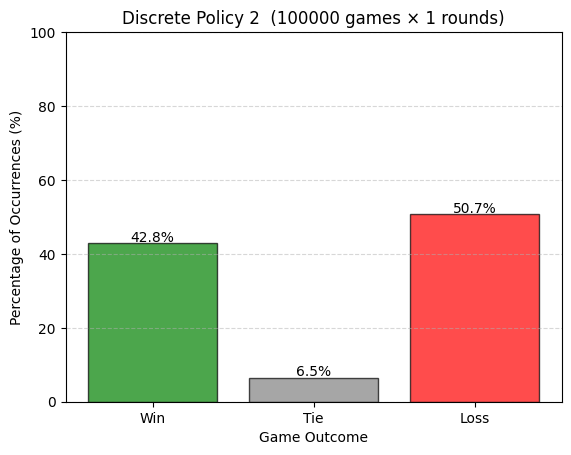

In [34]:
results = {}
num_rds = 1
num_games = 100000
wins=0
losses=0
ties=0
winp=0 #win percentage

# Store individual game outcomes here
returns = []

for i in range(num_games):
    result = play_game(discrete_policy2, num_rounds=num_rds)
    returns.append(result[0])
    wins+=result[1]
    losses+=result[2]
    


winp=wins/(num_games*num_rds) *100
lossp=losses/(num_games*num_rds) *100
tiep=100-(winp+lossp)


# Calculate the average
net_avg = sum(returns) / num_games

results[num_games] = net_avg

print(f"Average net return(%): {net_avg:.4f}")

print(f"Win(%): {winp:.4f}")

categories = ["Win", "Tie", "Loss"]
percentages = [winp, tiep, lossp]

plt.bar(categories, percentages, color=["green", "gray", "red"], alpha=0.7, edgecolor="black")
plt.title(f"Discrete Policy 2  ({num_games} games × {num_rds} rounds)")
plt.ylabel("Percentage of Occurrences (%)")
plt.xlabel("Game Outcome")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.ylim(0, 100)

# Display the value on top of each bar
for i, v in enumerate(percentages):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha="center", fontsize=10)

plt.show()

## Result discussion

When analysing the results over different sample sizes, it is possible to notice that the variability decreases significantly as the number of simulated games increases.
For example, with only 100 games, the outcomes fluctuate considerably from run to run, producing both positive and negative average returns. However, when running 100,000 simulations, the results stabilize and converge to nearly constant values, revealing the true expected performance of each policy.

This demonstrates the power of Monte Carlo simulation, as the number of iterations grows, randomness averages out, allowing for a more reliable estimation of a strategy’s expected outcome.

By comparing the results for the two Discrete Policies, we can observe that Discrete Policy 2 performs slightly better overall than Discrete Policy 1.

The average net return for Discrete Policy 1 is around -9.7% of the betted money, while Discrete Policy 2 achieves a higher value of −7.9%. Similarly, the win rate increases. Although both strategies still yield negative returns, meaning the player continues to lose money in the long run, the improvement of roughly 2% in both win rate and net return suggests that the second policy introduces small but meaningful optimizations in decision-making.

This improvement can be explained by the safer behaviour of Discrete Policy 2. Standing on all hands of 13 or higher avoids some unnecessary risks of busting that occur under Policy 1, which continues to hit until reaching 18. This allows the player to preserve more moderate-value hands that still have a chance to beat the dealer, especially when the dealer busts.

Overall, both strategies confirm the house advantage inherent in Blackjack, but also demonstrate how even simple strategy modifications can produce measurable differences when analysed through Monte Carlo simulation.

# Dataset with more than 2 dependent variables

To demonstrate methods such as PCA to reduce dimensionality we choose a dataset with more than 2 variables. Here our objective is not to encounter tendencies or do any data analysis, but apply this methods.

The chosen dataset is the “Iris Species” dataset, which consists of 150 flower samples distributed across three species: “Setosa”, "Versicolor”, and “Virginica”. Each instance includes four numerical attributes: sepal length, sepal width, petal length, and petal width, which serve as the dependent variables. The flower species is the categorical independent variable under study.

In [35]:
# Load dataset
data = pd.read_csv("iris_data.csv", header=None)

colunas = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species']

df = pd.read_csv('iris_data.csv', names=colunas, header=None)
display(df)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


## MANOVA

Multivariate Analysis of Variance (MANOVA) is a statistical method that extends the classic ANOVA to situations with two or more dependent variables. While ANOVA tests whether there are significant differences in means between groups for a single outcome, MANOVA assesses whether group differences exist when considering a combination of several outcome variables simultaneously. This approach is particularly advantageous when the dependent variables are correlated, as MANOVA evaluates group differences in the multivariate (combined) space, rather than individually for each response variable.

Applying MANOVA to the "Iris Species" dataset, we test whether the distribution of all four flower measurements differs by species. The table below summarizes the multivariate test results for the group effect:

In [36]:
# Perform MANOVA
manova = MANOVA.from_formula('SepalLengthCm + SepalWidthCm + PetalLengthCm + PetalWidthCm ~ Species', data=df)
print(manova.mv_test())

                   Multivariate linear model
                                                                
----------------------------------------------------------------
       Intercept         Value  Num DF  Den DF   F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda  0.0170 4.0000 144.0000 2080.5278 0.0000
         Pillai's trace  0.9830 4.0000 144.0000 2080.5278 0.0000
 Hotelling-Lawley trace 57.7924 4.0000 144.0000 2080.5278 0.0000
    Roy's greatest root 57.7924 4.0000 144.0000 2080.5278 0.0000
----------------------------------------------------------------
                                                                
----------------------------------------------------------------
        Species          Value  Num DF  Den DF   F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda  0.0235 8.0000 288.0000  198.7110 0.0000
         Pillai's trace  1.1872 8.0000 290.00

All reported multivariate test statistics (Wilks' lambda, Pillai's trace, Hotelling-Lawley trace, and Roy's greatest root) indicate extremely significant results, with p-values far below 0.001. This means that, when the four characteristics of Iris flowers are considered together, the mean vectors among the species are significantly different. Wilks’ lambda being very close to zero also suggests a strong difference among the group means in the combined multivariate space.

All tests produce extremely significant results (p < 0.001), indicating that the mean vectors are not equal across species. In particular, the low Wilks’ lambda (0.0235) demonstrates strong differences among the groups in the multivariate space.

## PCA

To complement the MANOVA, we performed Principal Component Analysis (PCA) on the same dataset. PCA is a dimensionality reduction technique that transforms the original variables into a new set of uncorrelated variables (principal components), ordered so that the first few capture most of the variance in the data.

In [37]:
# Input features
X = df.iloc[:, 0:4]
#Target
y = df['Species']

In [38]:
# Mean
X_mean = X.mean()

# Standard deviation
X_std = X.std()

# Standardization
Z = (X - X_mean) / X_std

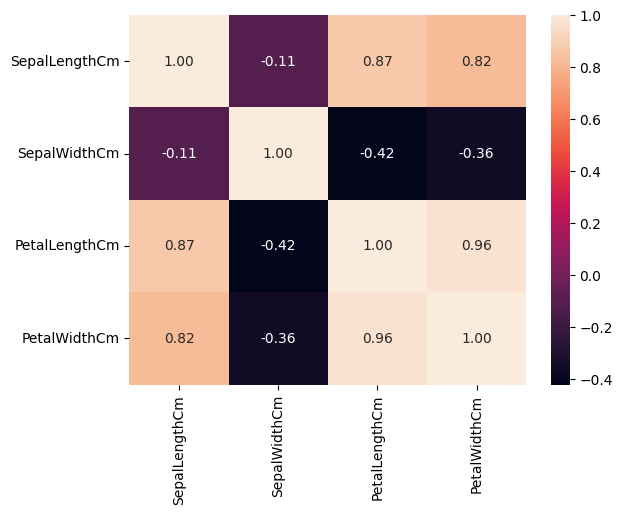

In [39]:
# Covariance
c = Z.cov()

sns.heatmap(c, annot=True, fmt='.2f')
plt.show()

In [40]:
eigenvalues, eigenvectors = np.linalg.eig(c)
print('Eigen values:\n', eigenvalues)
print('Eigen values Shape:', eigenvalues.shape)
print('Eigen Vector Shape:', eigenvectors.shape)

Eigen values:
 [2.91081808 0.92122093 0.14735328 0.02060771]
Eigen values Shape: (4,)
Eigen Vector Shape: (4, 4)


Sort the eigenvalues in descending order and sort the corresponding eigenvectors accordingly.

In [41]:
# Index the eigenvalues in descending order 
idx = eigenvalues.argsort()[::-1]

# Sort the eigenvalues in descending order 
eigenvalues = eigenvalues[idx]

# sort the corresponding eigenvectors accordingly
eigenvectors = eigenvectors[:,idx]

Explained variance is the term that gives us an idea of the amount of the total variance which has been retained by selecting the principal components instead of the original feature space.

In [42]:
explained_var = np.cumsum(eigenvalues) / np.sum(eigenvalues)
explained_var

array([0.72770452, 0.95800975, 0.99484807, 1.        ])

The first two principal components explained over 95% of the total variance in the dataset.

In [43]:
# Considering 2 components 
n_components = 2 
pca = PCA(n_components)
pca.fit(Z)
x_pca = pca.transform(Z)

# Create the dataframe
df_pca1 = pd.DataFrame(x_pca,
                       columns=['PC{}'.
                       format(i+1)
                        for i in range(n_components)])
print(df_pca1)

          PC1       PC2
0   -2.256981  0.504015
1   -2.079459 -0.653216
2   -2.360044 -0.317414
3   -2.296504 -0.573447
4   -2.380802  0.672514
..        ...       ...
145  1.864277  0.381544
146  1.553288 -0.902291
147  1.515767  0.265904
148  1.371796  1.012968
149  0.956096 -0.022210

[150 rows x 2 columns]


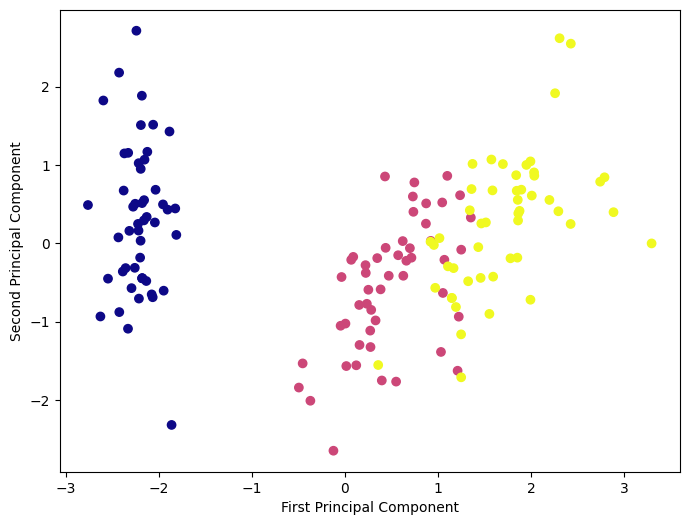

In [44]:
#change the values of the last column
def conversion(species):
    if species == 'Iris-setosa':
        return 0
    elif species == 'Iris-versicolor':
        return 1
    elif species == 'Iris-virginica':
        return 2
    else:
        return np.nan

# Substituir os valores da última coluna
y_conversion = y.apply(conversion)

# giving a larger plot
plt.figure(figsize=(8, 6))

plt.scatter(x_pca[:, 0], x_pca[:, 1],
            c=y_conversion,
            cmap='plasma')

# labeling x and y axes
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

A 2D scatter plot of the samples projected onto the first two principal components shows a clear separation among the three species, especially Setosa, while Versicolor and Virginica exhibit some overlap.

## Conclusion

Both MANOVA and PCA results strongly indicate that the three Iris species are distinguishable when considering all four measurements together. MANOVA provides formal statistical confirmation of group differences, while PCA offers visual insight into the data’s structure and how most of the information can be contained in just two principal components.